# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

# Import Libraries

In [254]:
import pandas as pd
import plotly.express as px

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler


import pickle


# Load Data

In [258]:
data = pd.read_csv('data/bike-sharing_hourly.csv')

In [259]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# PART I: Exploratory Data Analysis

### Data Quality

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [12]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


,time,relative_humidity_2m,apparent_temperature,rain,snowfall,wind_speed_10m,temperature_80m
0,2024-03-13T00:00,27,-0.4,0.0,0.0,9.0,6.7
1,2024-03-13T01:00,31,-0.9,0.0,0.0,9.1,6.2
2,2024-03-13T02:00,34,-1.7,0.0,0.0,10.4,6.0
3,2024-03-13T03:00,36,-2.2,0.0,0.0,8.7,5.8
4,2024-03-13T04:00,36,-2.3,0.0,0.0,11.7,5.6


In [6]:
data.nunique()

instant       17379
dteday          731
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             50
atemp            65
hum              89
windspeed        30
casual          322
registered      776
cnt             869
dtype: int64

In [7]:
for column in data.columns:
    col_name = (column + ": ").ljust(20, " ")
    print(col_name, *data[column].unique()[0:5], sep="\t", end="\n")

instant:            	1	2	3	4	5
dteday:             	2011-01-01	2011-01-02	2011-01-03	2011-01-04	2011-01-05
season:             	1	2	3	4
yr:                 	0	1
mnth:               	1	2	3	4	5
hr:                 	0	1	2	3	4
holiday:            	0	1
weekday:            	6	0	1	2	3
workingday:         	0	1
weathersit:         	1	2	3	4
temp:               	0.24	0.22	0.2	0.32	0.38
atemp:              	0.2879	0.2727	0.2576	0.3485	0.3939
hum:                	0.81	0.8	0.75	0.86	0.76
windspeed:          	0.0	0.0896	0.2537	0.2836	0.2985
casual:             	3	8	5	0	2
registered:         	13	32	27	10	1
cnt:                	16	40	32	13	1


In [8]:
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [9]:
duplicates = data[data.duplicated()]
print(f"Number of duplicates found: {len(duplicates)}")

Number of duplicates found: 0


### Data Visualization

In [158]:
# group data by day and sum the number of rentals
daily_rentals = data.groupby('dteday')['cnt'].sum()

# Get the date with the highest number of rentals
max_rentals = daily_rentals.idxmax()
max_rentals_count = daily_rentals.max()
print(f"The day with the most rentals is {max_rentals} with {max_rentals_count} rentals")

The day with the most rentals is 2012-09-15 00:00:00 with 8714 rentals


In [250]:
# year and month with most rentals
monthly_rentals = data.groupby(['yr', 'mnth'])['cnt'].sum()
display(monthly_rentals)
max_monthly_rentals = monthly_rentals.idxmax()
max_monthly_rentals_count = monthly_rentals.max()
print(f"The month with the most rentals is {max_monthly_rentals[1]} of {max_monthly_rentals[0]} with {max_monthly_rentals_count} rentals")

yr  mnth
0   1        38189
    2        48215
    3        64045
    4        94870
    5       135821
    6       143512
    7       141341
    8       136691
    9       127418
    10      123511
    11      102167
    12       87323
1   1        96744
    2       103137
    3       164875
    4       174224
    5       195865
    6       202830
    7       203607
    8       214503
    9       218573
    10      198841
    11      152664
    12      123713
Name: cnt, dtype: int64

The month with the most rentals is 9 of 1 with 218573 rentals


In [252]:
# Average temperature for september
september = data[data['mnth'] == 9]
average_temp_september = september['temp'].mean()
print(f"The average temperature in September is {average_temp_september:.2f}°C")

The average temperature in September is 0.62°C


In [251]:
# temperature vs rentals
fig = px.scatter(data, x='temp', y='cnt', trendline='ols')
fig.show()

In [240]:
data['dteday'] = pd.to_datetime(data['dteday'])

# Group by 'dteday' and sum the 'cnt' for each day
daily_counts = data.groupby(['dteday'])['cnt'].sum().reset_index()

month = 3

# Filter the data for a month
monthly_y1_df = daily_counts[daily_counts['dteday'].dt.month == month][daily_counts['dteday'].dt.year == 2011].reset_index(drop=True)
monthly_y2_df = daily_counts[daily_counts['dteday'].dt.month == month][daily_counts['dteday'].dt.year == 2012].reset_index(drop=True)
monthly_y2_df['cnt_y1'] = monthly_y1_df['cnt']

display(monthly_y2_df.head())




/var/folders/2b/0rq4mprx3cb7w7bffk181n3m0000gn/T/ipykernel_94654/2688366641.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/2b/0rq4mprx3cb7w7bffk181n3m0000gn/T/ipykernel_94654/2688366641.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,dteday,cnt,cnt_y1
0,2012-03-01,4990,1851
1,2012-03-02,3194,2134
2,2012-03-03,4066,1685
3,2012-03-04,3423,1944
4,2012-03-05,3333,2077


In [241]:
# Create a Plotly line chart with both years overlaid
fig = px.line(monthly_y2_df, x='dteday', y=['cnt', 'cnt_y1'],
              labels={'cnt': 'Total Bike Counts', 'dteday': 'Date', 'year': 'Year'},
              title='Overlay of Bike Counts for Each Year')

# Show the Plotly chart
fig.show()

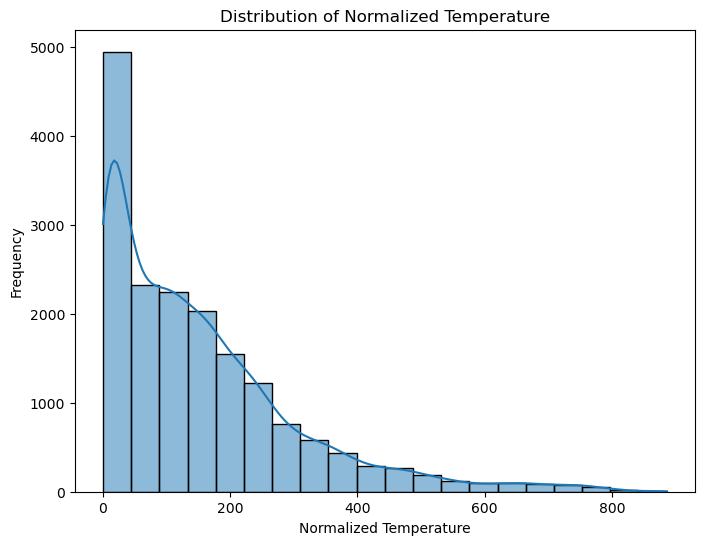

In [29]:


plt.figure(figsize=(8, 6))
sns.histplot(data['registered'], bins=20, kde=True)
plt.title('Distribution of Normalized Temperature')
plt.xlabel('Normalized Temperature')
plt.ylabel('Frequency')
plt.show()

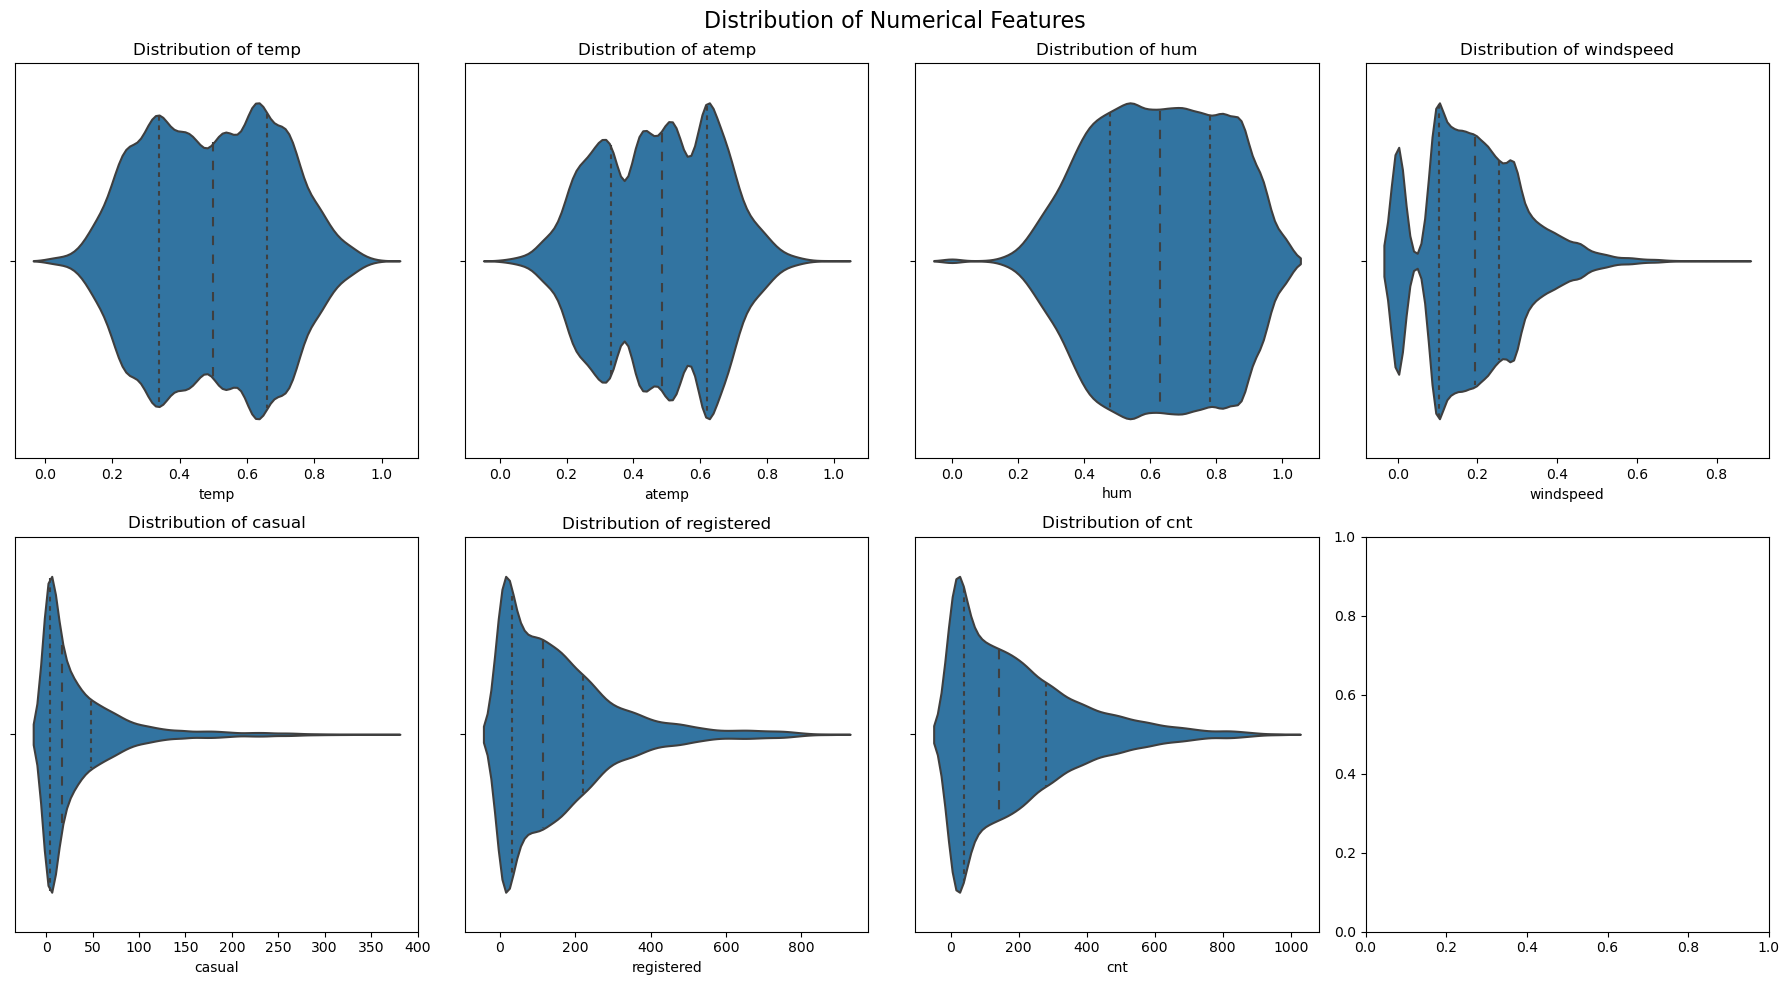

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fig.suptitle('Distribution of Numerical Features', fontsize=16)

# Flatten the axes for easier iteration
axes = axes.flatten()

# Create violin plots for each numerical feature
for i, feature in enumerate(numerical_features):
    sns.violinplot(x=feature, data=data, ax=axes[i], inner='quartile')
    axes[i].set_title(f'Distribution of {feature}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


IndexError: index 6 is out of bounds for axis 0 with size 6

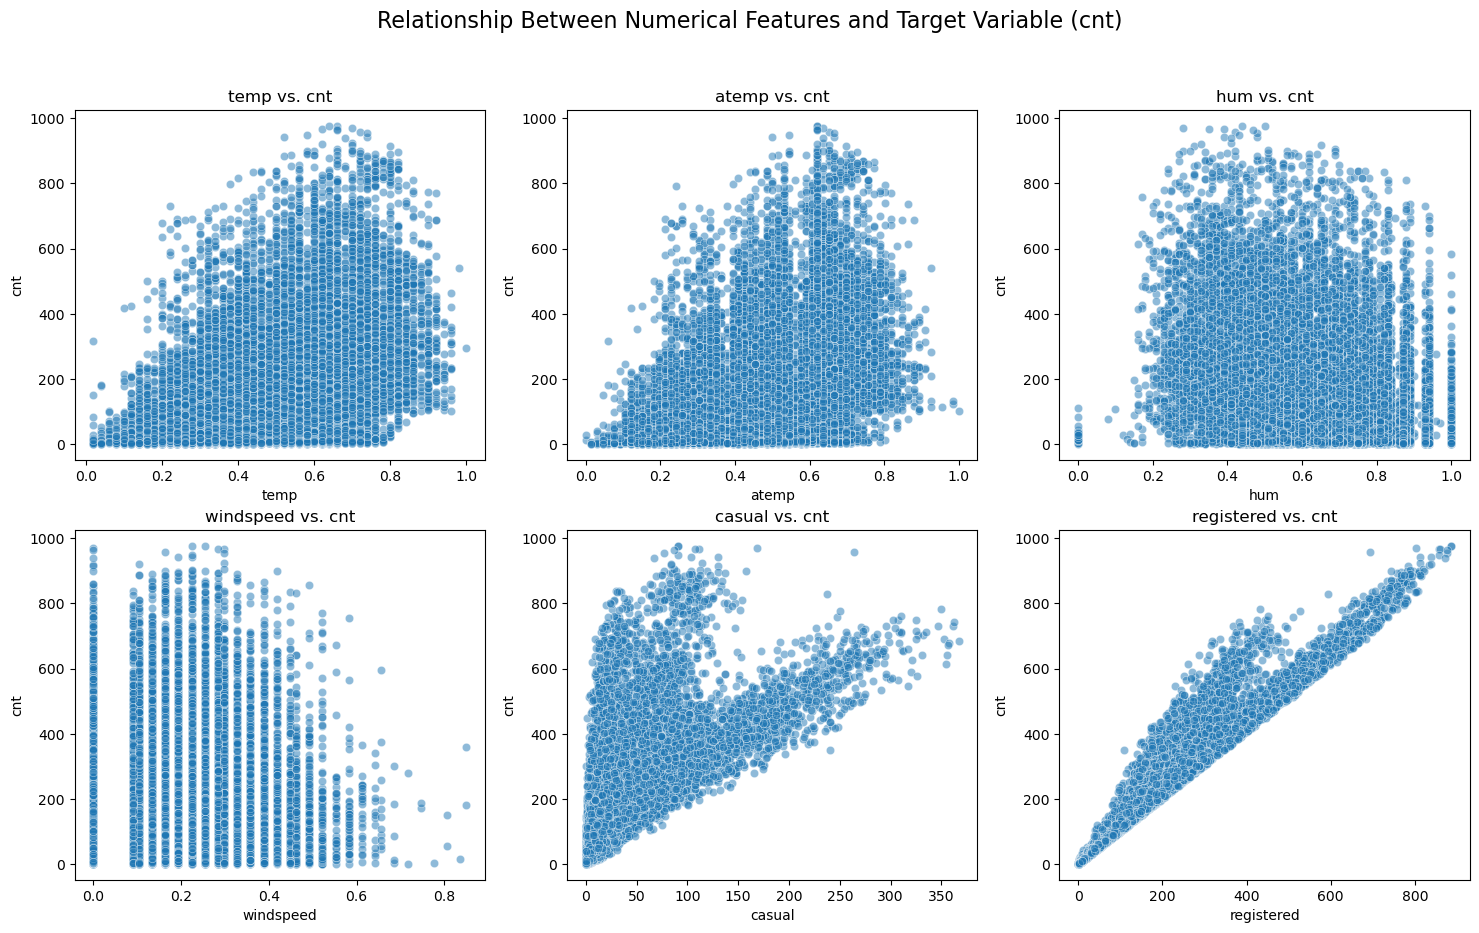

In [25]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Relationship Between Numerical Features and Target Variable (cnt)', fontsize=16)

# Flatten the axes for easier iteration
axes = axes.flatten()

# Create scatter plots for each numerical feature against the target variable
for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=feature, y='cnt', data=data, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{feature} vs. cnt')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

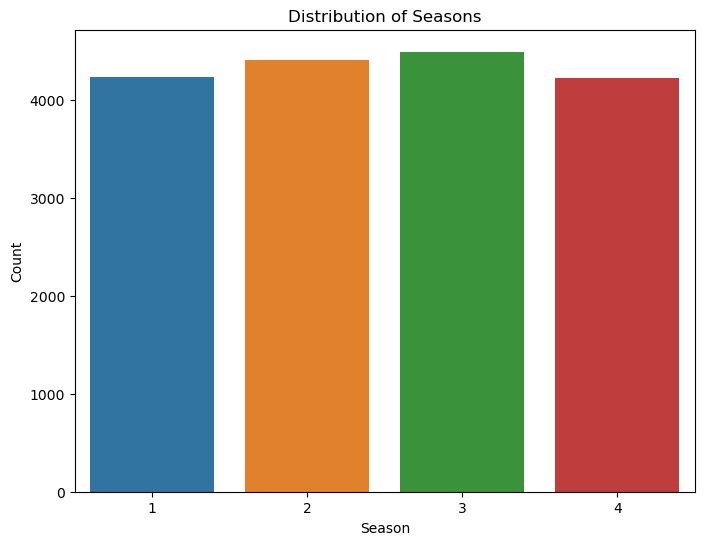

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='season', data=data)
plt.title('Distribution of Seasons')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

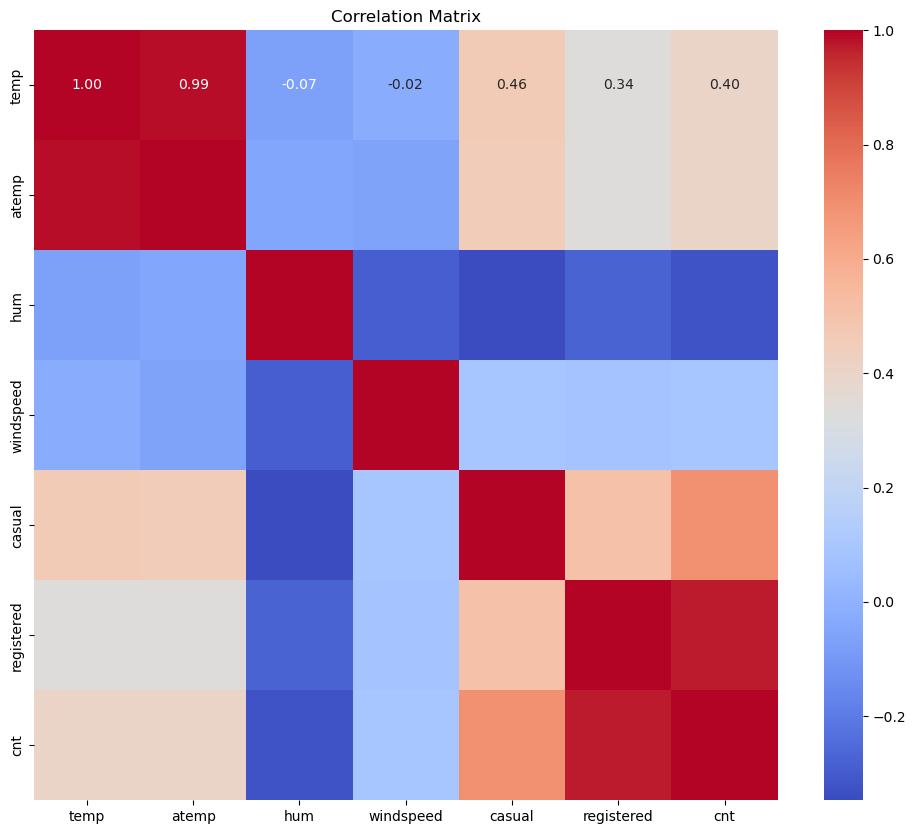

In [19]:
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
category_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
# Calculate correlation matrix
correlation_matrix = data[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

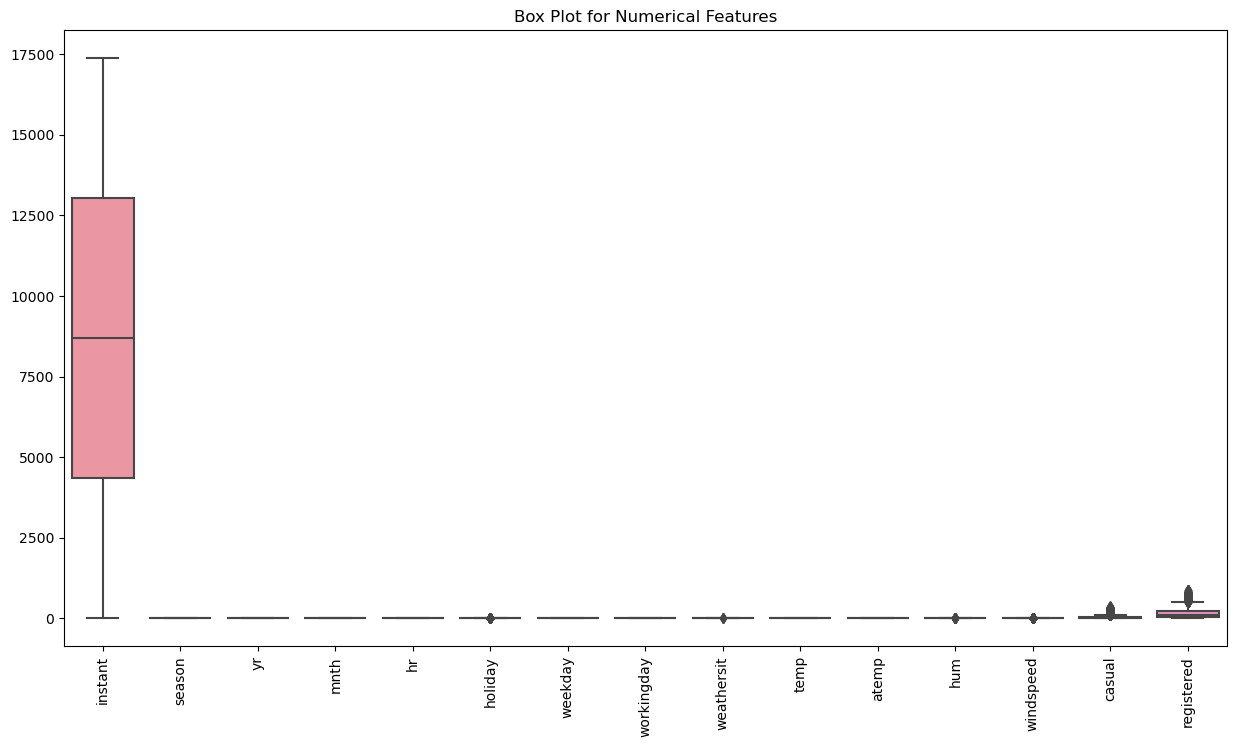

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
sns.boxplot(data=data.drop(['cnt'], axis=1))
plt.title('Box Plot for Numerical Features')
plt.xticks(rotation=90)
plt.show()

/var/folders/2b/0rq4mprx3cb7w7bffk181n3m0000gn/T/ipykernel_67639/3267573342.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


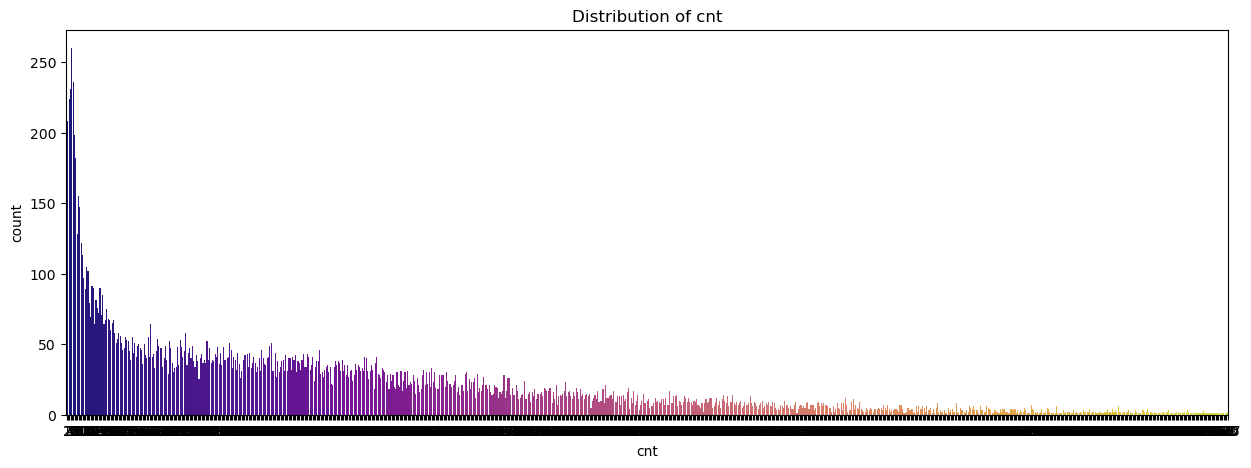

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(data=data,x="cnt", palette = "plasma");
plt.title("Distribution of cnt")

fig.show();

## Feature Engineering

### Train/Test Split

### Feature Selection

Should I remove casual and registered? What do they add to my model?

In [260]:
columns_to_drop = ['instant', 'dteday', 'casual', 'registered', 'yr']

### Data Types

It doesnt look like we need to encode the categorical variables. They are for the most part ordinal. Like `weathersit` which goes from light weather to heavy weather.

In [261]:
cat_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']


# PART II: Prediction Model

## Arrange the data

In [293]:
X = data.drop(['cnt'] + columns_to_drop, axis=1)
y = data['cnt']

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create a pipeline

In [304]:
lgbm = lgb.LGBMRegressor(random_state=0)

param_grid = {
    'num_leaves': randint(30, 50),
    "max_depth": randint(3, 10),
    "n_estimators": randint(100, 150),
    "learning_rate": uniform(0.03, 0.3),
}

rf_cv = RandomizedSearchCV(lgbm, param_grid, scoring='neg_mean_squared_error', cv=5, refit='neg_mean_squared_error', n_jobs=-1, verbose=2, n_iter=10, return_train_score=True)

In [305]:
# Define the preprocessor to drop columns and apply standard scaling
preprocessor = ColumnTransformer(
    transformers=[
        #('drop_columns', 'drop', columns_to_drop),
        ('num', RobustScaler(), X.columns)  # Assuming all remaining columns are numerical
    ]
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf_cv)  # Replace with your chosen regression model
])

## Fit the model

In [306]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set (replace with appropriate evaluation metrics)
score = pipeline.score(X_test, y_test)
print(f'Model Score: {score}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274[LightGBM] [Info] Total Bins 272

[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 11122, number of used features: 11
[LightGBM] [Info] Number of data points in the train set: 11123, number of used features: 11
[LightGBM] [Info] Number of data points in the train set: 11122, number of used features: 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

In [307]:
# test the model
y_pred = pipeline.predict(X_test)
y_pred

array([400.15817054,  85.94391958,   1.45621741, ...,  99.77744161,
       315.52476014, 347.14176512])

## Evaluate

In [308]:
# test scores
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 3770.9106088574404
Mean Absolute Error: 40.962176388219014
R^2 Score: 0.8809138915395692


In [309]:
# scatter plot of the test target variable with plotly
fig = px.scatter(x=y_test, y=y_pred, labels={'x': 'True Values', 'y': 'Predicted Values'}, title='Predicted vs True Values')
fig.add_shape(type='line', line=dict(dash='dash'), x0=y_test.min(), x1=y_test.max(), y0=y_test.min(), y1=y_test.max())
fig.show()


## Save the model

In [310]:
# Pickle the model
with open('models/reg.pickle', 'wb') as to_write:
    pickle.dump(pipeline, to_write)

# PART III: Streamlit dashboard

In [138]:
import requests
min_temp = -10.0
max_temp = 40.0
default_temp = 15.0

min_windspeed = 0
max_windspeed = 67
default_windspeed = 10

response = requests.get("https://api.open-meteo.com/v1/forecast?latitude=42.361145&longitude=-71.057083&hourly=relative_humidity_2m,apparent_temperature,rain,snowfall,wind_speed_10m,temperature_80m&timezone=America%2FNew_York")
response.json()['hourly']
weather_df = pd.DataFrame(response.json()['hourly'])
weather_df.head()

,time,relative_humidity_2m,apparent_temperature,rain,snowfall,wind_speed_10m,temperature_80m
0,2024-03-13T00:00,27,-0.4,0.0,0.0,9.0,6.7
1,2024-03-13T01:00,31,-0.9,0.0,0.0,9.1,6.2
2,2024-03-13T02:00,34,-1.7,0.0,0.0,10.4,6.0
3,2024-03-13T03:00,36,-2.2,0.0,0.0,8.7,5.8
4,2024-03-13T04:00,36,-2.3,0.0,0.0,11.7,5.6


In [139]:
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df['mnth'] = weather_df['time'].dt.month
weather_df['hr'] = weather_df['time'].dt.hour
weather_df['temp'] = (weather_df['temperature_80m'] - min_temp) / (max_temp - min_temp)
weather_df['atemp'] = (weather_df['apparent_temperature'] - min_temp) / (max_temp - min_temp)
weather_df['windspeed'] = (weather_df['wind_speed_10m'] - min_windspeed) / (max_windspeed - min_windspeed)
weather_df['hum'] = weather_df['relative_humidity_2m'] / 100
weather_df['weekday'] = weather_df['time'].dt.dayofweek
weather_df['season'] = (weather_df['mnth'] % 12 + 3) // 3
weather_df['holiday'] = 0
weather_df['workingday'] = weather_df['weekday'].apply(lambda x: 1 if x < 5 else 0)
weather_df['weathersit'] = 1
weather_prepared_df = weather_df.drop(columns=['apparent_temperature', 'temperature_80m', 'wind_speed_10m', 'relative_humidity_2m', 'rain', 'snowfall'])
column_names = ['time', 'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
weather_prepared_df = weather_prepared_df[column_names]

weather_prepared_df.head()

,time,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2024-03-13 00:00:00,2,3,0,0,2,1,1,0.334,0.192,0.27,0.134328
1,2024-03-13 01:00:00,2,3,1,0,2,1,1,0.324,0.182,0.31,0.135821
2,2024-03-13 02:00:00,2,3,2,0,2,1,1,0.320,0.166,0.34,0.155224
3,2024-03-13 03:00:00,2,3,3,0,2,1,1,0.316,0.156,0.36,0.129851
4,2024-03-13 04:00:00,2,3,4,0,2,1,1,0.312,0.154,0.36,0.174627


In [140]:
#predict the bike count
filtered_df = weather_prepared_df.drop(columns=['time'])
weather_pred = pipeline.predict(filtered_df)

complete_df = pd.concat([weather_prepared_df, pd.DataFrame(weather_pred, columns=['predicted_cnt'])], axis=1)

display(complete_df.head())
flitered_forecast_w2 = complete_df['weathersit'].apply(lambda x: 2 if x == 1 else 0)
display(flitered_forecast_w2.head())



,time,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,predicted_cnt
0,2024-03-13 00:00:00,2,3,0,0,2,1,1,0.334,0.192,0.27,0.134328,3
1,2024-03-13 01:00:00,2,3,1,0,2,1,1,0.324,0.182,0.31,0.135821,3
2,2024-03-13 02:00:00,2,3,2,0,2,1,1,0.320,0.166,0.34,0.155224,1
3,2024-03-13 03:00:00,2,3,3,0,2,1,1,0.316,0.156,0.36,0.129851,1
4,2024-03-13 04:00:00,2,3,4,0,2,1,1,0.312,0.154,0.36,0.174627,1


0    2
1    2
2    2
3    2
4    2
Name: weathersit, dtype: int64

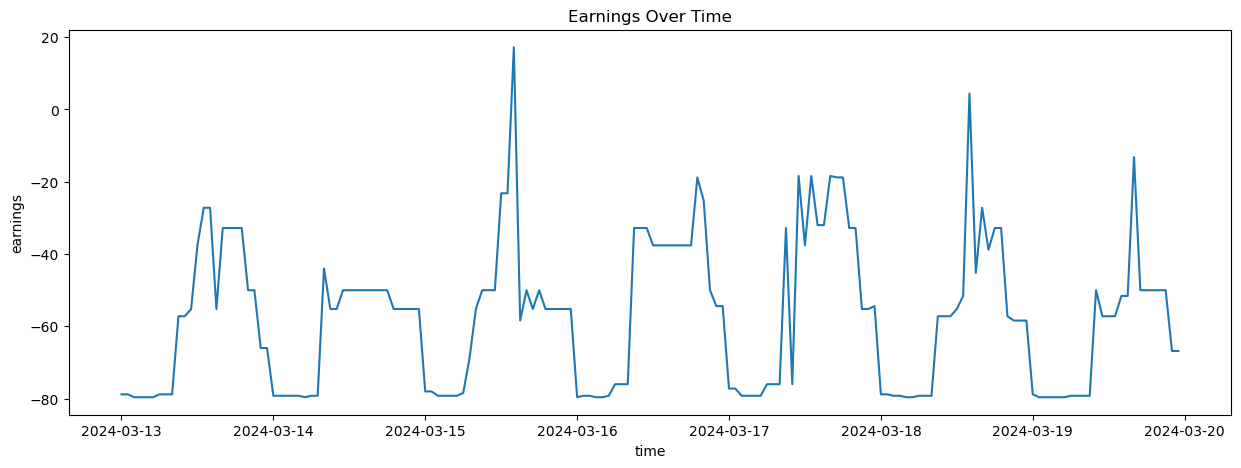

Total Earnings: -9613.599999999999


In [141]:
OperationalCost = 80
Revenue = 0.4
complete_df['earnings'] = (complete_df['predicted_cnt'] * Revenue) - OperationalCost
# plot the earnings
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(data=complete_df, x='time', y='earnings')
plt.title("Earnings Over Time")
plt.show()

#print total earninigs
total_earnings = complete_df['earnings'].sum()
print(f'Total Earnings: {total_earnings}')